In [1]:
import pandas as pd
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from functools import lru_cache

In [2]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [3]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [4]:
REMOVE_KEYWORDS = True
removal_keywords = ["credit card", "air force"]


In [22]:
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
default_scores = []
global_explanation = ""

for year in session_year_map:
    global_explanation += f"-------------------\n--------------------\nYear: {year}\n"
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv") 
    if REMOVE_KEYWORDS:
        keywords_df = keywords_df[~keywords_df["phrase_clean"].isin(removal_keywords)]

    valid_columns = [col for col in website_df.columns if str(year) in col]
    last_month_column = valid_columns[-1]

    subset = website_df[last_month_column]
    subset = subset.fillna("")
    subset = subset.astype(str)

    website_scores = []

    y_n_denominator = sum([(beta * beta) for beta in keywords_df["beta"]])
    default_y_n_numerator = sum([(beta * (0 - alpha)) for (beta, alpha) in zip(keywords_df["beta"], keywords_df["alpha"])])
    print("default y_n_numerator: ", default_y_n_numerator)
    print("y_n_denominator: ", y_n_denominator)
    default_scores.append(default_y_n_numerator / y_n_denominator)

    for website in tqdm(subset):
        phrase_counts = {}
        phrase_counts_sum = 0
        for phrase in keywords_df["phrase_clean"]:
            phrase_counts[phrase] = website.lower().count(phrase)
            phrase_counts_sum += phrase_counts[phrase]
            if phrase_counts[phrase] > 100:
                print("Phrase: ", phrase)
        
        score = None
        explanation = ""
        if phrase_counts_sum == 0:
            score = (default_y_n_numerator / y_n_denominator)
        else:
            y_n_numerator = 0
            for (phrase, beta, alpha) in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
                y_n_numerator += beta * ((phrase_counts[phrase] / phrase_counts_sum) - alpha)
                if phrase_counts[phrase] > 0:
                    explanation += f"Phrase: {phrase}, Count: {phrase_counts[phrase]}, Total phrases counted: {phrase_counts_sum}, Addition to total score: {beta * (phrase_counts[phrase] / phrase_counts_sum) / y_n_denominator}\n"
            score = (y_n_numerator / y_n_denominator)
        
        if score > 2 or score < -0.75:
            global_explanation += f"\nWebsite: \n {website}\n\nWebsite score: {score}\n\n{explanation}\n\n\n==============="

        website_scores.append(score)
    all_website_scores.append(website_scores)
    
    print(f"Year {year} score: {np.mean(website_scores)} +/- {np.std(website_scores)}")

default y_n_numerator:  0.020042028303114672
y_n_denominator:  0.033244439829346877


100%|██████████| 5189/5189 [00:03<00:00, 1483.76it/s]


Year 2007 score: 0.603934902793046 +/- 0.059246258139116346
default y_n_numerator:  0.020042028303114672
y_n_denominator:  0.033244439829346877


100%|██████████| 5189/5189 [00:04<00:00, 1253.83it/s]


Year 2008 score: 0.603185098502899 +/- 0.062141819084700144
default y_n_numerator:  0.01347384819719851
y_n_denominator:  0.02480827703670454


100%|██████████| 5189/5189 [00:04<00:00, 1084.98it/s]


Year 2009 score: 0.5363513293332254 +/- 0.08511964800546716
default y_n_numerator:  0.01347384819719851
y_n_denominator:  0.02480827703670454


100%|██████████| 5189/5189 [00:05<00:00, 884.77it/s] 


Year 2010 score: 0.5348302309479205 +/- 0.09260685245930124
default y_n_numerator:  0.009928481533953622
y_n_denominator:  0.025680847759752438


100%|██████████| 5189/5189 [00:07<00:00, 709.64it/s]


Year 2011 score: 0.3848604478045469 +/- 0.07672980197156039
default y_n_numerator:  0.009928481533953622
y_n_denominator:  0.025680847759752438


100%|██████████| 5189/5189 [00:07<00:00, 670.08it/s]


Year 2012 score: 0.38247372155753784 +/- 0.08164390364844214
default y_n_numerator:  0.015008291064897091
y_n_denominator:  0.04874024530623686


100%|██████████| 5189/5189 [00:09<00:00, 570.73it/s]


Year 2013 score: 0.31086055422158004 +/- 0.09304489379397363
default y_n_numerator:  0.015008291064897091
y_n_denominator:  0.04874024530623686


100%|██████████| 5189/5189 [00:10<00:00, 487.20it/s]


Year 2014 score: 0.31144598376313487 +/- 0.09898727421414594
default y_n_numerator:  0.014546896207992757
y_n_denominator:  0.042960194117697074


100%|██████████| 5189/5189 [00:12<00:00, 414.89it/s]


Year 2015 score: 0.3365515489112708 +/- 0.07923807186211304
default y_n_numerator:  0.014546896207992757
y_n_denominator:  0.042960194117697074


100%|██████████| 5189/5189 [00:13<00:00, 376.53it/s]


Year 2016 score: 0.33614168272815775 +/- 0.08397345283998928
default y_n_numerator:  0.019194375105145413
y_n_denominator:  0.037252241893798846


100%|██████████| 5189/5189 [00:14<00:00, 350.18it/s]


Year 2017 score: 0.5194984379202583 +/- 0.143182192292261
default y_n_numerator:  0.019194375105145413
y_n_denominator:  0.037252241893798846


100%|██████████| 5189/5189 [00:17<00:00, 296.76it/s]


Year 2018 score: 0.5226742470225861 +/- 0.15638267808692707
default y_n_numerator:  0.023632993683566677
y_n_denominator:  0.0546721376933186


100%|██████████| 5189/5189 [00:18<00:00, 276.96it/s]


Year 2019 score: 0.45324691020958624 +/- 0.13955109754195547
default y_n_numerator:  0.023632993683566677
y_n_denominator:  0.0546721376933186


100%|██████████| 5189/5189 [00:22<00:00, 231.56it/s]

Year 2020 score: 0.45578490060788457 +/- 0.1505305553624054


In [23]:
with open("outlier_website_scores_explanation.txt", "w") as f:
    f.write(global_explanation)
    f.write("\n\n\n\n")
    f.close()

Number of scores:  5189
Number of scores:  5189
Number of scores:  5189
Number of scores:  5189


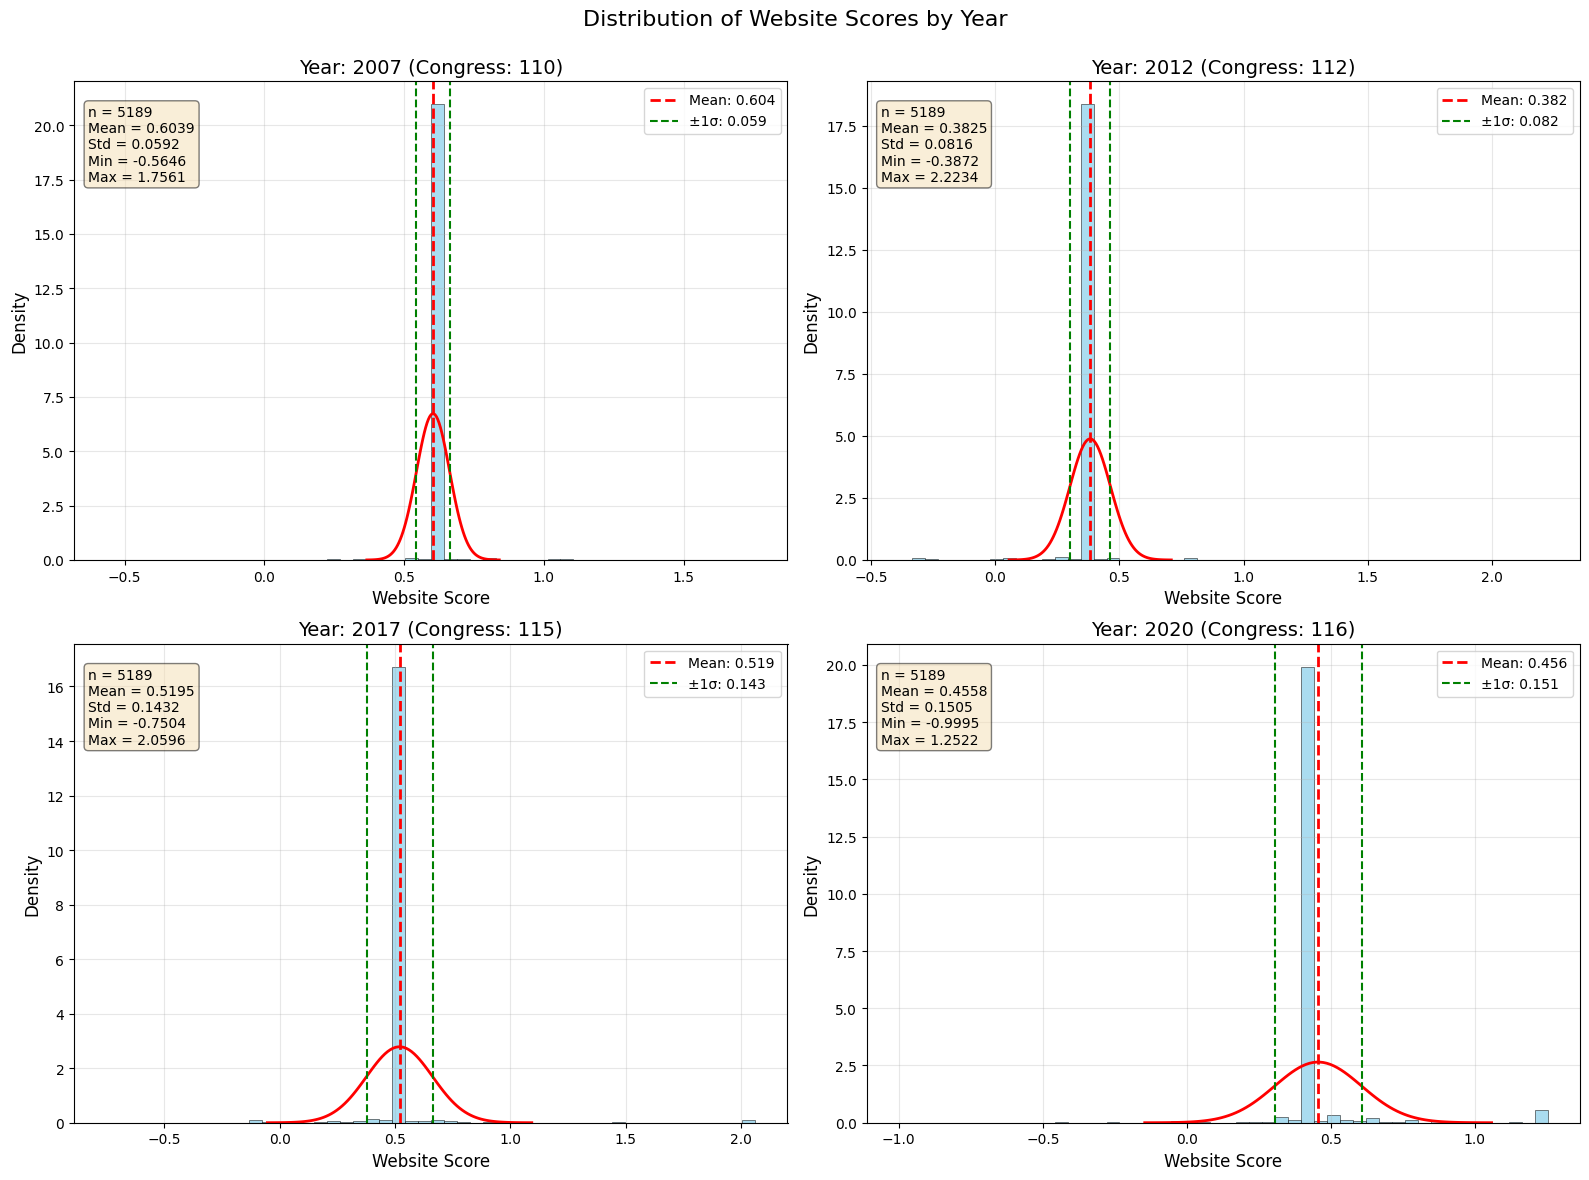

In [7]:
# claude visualization

import numpy as np

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Website Scores by Year', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

for i, year_idx in enumerate([0, 5, 10, 13]):  # Sample early, middle, and recent years
    year = list(session_year_map.keys())[year_idx]
    scores = all_website_scores[year_idx]
    print("Number of scores: ", len(scores))
    # scores = scores[:200]
    
    # Calculate statistics
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Plot histogram with density curve
    ax = axes[i]
    n, bins, patches = ax.hist(scores, bins=50, alpha=0.7, density=True, 
                               color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add normal distribution curve
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    ax.plot(x, y, 'r-', linewidth=2)
    
    # Add vertical lines for mean and standard deviations
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    ax.axvline(mean + std, color='green', linestyle='dashed', linewidth=1.5, label=f'±1σ: {std:.3f}')
    ax.axvline(mean - std, color='green', linestyle='dashed', linewidth=1.5)
    
    # Add title and labels
    ax.set_title(f'Year: {year} (Congress: {session_year_map[year]})', fontsize=14)
    ax.set_xlabel('Website Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add text with statistics
    text = f'n = {len(scores)}\nMean = {mean:.4f}\nStd = {std:.4f}\nMin = {min(scores):.4f}\nMax = {max(scores):.4f}'
    ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [8]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.603934902793046, 0.603185098502899, 0.5363513293332254, 0.5348302309479205, 0.3848604478045469, 0.38247372155753784, 0.31086055422158004, 0.31144598376313487, 0.3365515489112708, 0.33614168272815775, 0.5194984379202583, 0.5226742470225861, 0.45324691020958624, 0.45578490060788457]
[0.059246258139116346, 0.062141819084700144, 0.08511964800546716, 0.09260685245930124, 0.07672980197156039, 0.08164390364844214, 0.09304489379397363, 0.09898727421414594, 0.07923807186211304, 0.08397345283998928, 0.143182192292261, 0.15638267808692707, 0.13955109754195547, 0.1505305553624054]


In [9]:
print([np.sum(scores) for scores in all_website_scores])

[3133.8182105931155, 3129.927476131543, 2783.1270479101067, 2775.2340683887596, 1997.040863657794, 1984.6561411620637, 1613.0554158557788, 1616.0932097469067, 1746.3659873005843, 1744.2391916764107, 2695.67739436822, 2712.1566678001996, 2351.898217077543, 2365.067849254313]


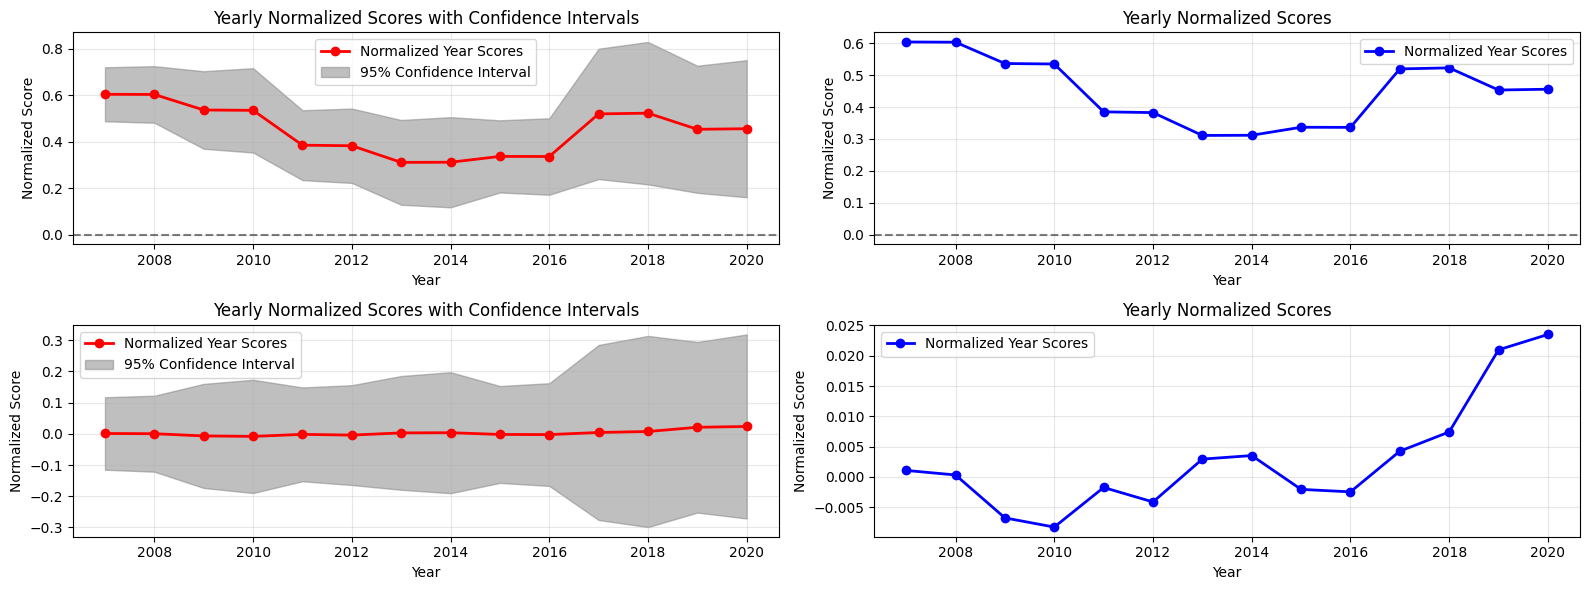

Years: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [14]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
year_scores = [np.mean(scores) for scores in all_website_scores]
year_std_devs = [np.std(scores) for scores in all_website_scores]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6))

# Plot 1: With confidence intervals
ax1.plot(years, year_scores, 
         marker='o', color='r', linewidth=2, label='Normalized Year Scores')
ax1.fill_between(years, 
                 [score - 1.96*std for score, std in zip(year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(year_scores, year_std_devs)], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')
ax1.set_xlabel('Year')
ax1.set_ylabel('Normalized Score')
ax1.set_title('Yearly Normalized Scores with Confidence Intervals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Without confidence intervals
ax2.plot(years, year_scores, 
         marker='o', color='b', linewidth=2, label='Normalized Year Scores')
ax2.set_xlabel('Year')
ax2.set_ylabel('Normalized Score')
ax2.set_title('Yearly Normalized Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: With confidence intervals, subtracting the mean
ax3.plot(years, [score - default_score for (score, default_score) in zip(year_scores, default_scores)], 
         marker='o', color='r', linewidth=2, label='Normalized Year Scores')
ax3.fill_between(years, 
                 [score - default_score - 1.96*std for score, default_score, std in zip(year_scores, default_scores, year_std_devs)], 
                 [score - default_score + 1.96*std for score, default_score, std in zip(year_scores, default_scores, year_std_devs)], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')
ax3.set_xlabel('Year')
ax3.set_ylabel('Normalized Score')
ax3.set_title('Yearly Normalized Scores with Confidence Intervals')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Without confidence intervals
ax4.plot(years, [score - default_score for (score, default_score) in zip(year_scores, default_scores)], 
         marker='o', color='b', linewidth=2, label='Normalized Year Scores')
ax4.set_xlabel('Year')
ax4.set_ylabel('Normalized Score')
ax4.set_title('Yearly Normalized Scores')
ax4.legend()
ax4.grid(True, alpha=0.3)


# Add a horizontal line at y=0 for reference in both plots
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print the values for reference
print("Years:", years)

In [ ]:
import pickle

for year in phrase_count_by_year:
    print("Year: ", year)
    print(phrase_count_by_year[year].sum(axis=0).sort_values(ascending=False).head(15))
    print("\n\n----\n\n")

Year:  2007
phrase_clean
new mexico           30
natural gas          20
health care          17
health insurance     14
god bless            12
student loan         11
made order            9
civil war             8
white house           7
renewable energy      6
consumer product      6
homeland security     5
solve problem         5
get health            5
health safety         5
dtype: int64


----


Year:  2008
phrase_clean
new mexico          29
health care         17
renewable energy    15
made order          15
god bless           12
health insurance    11
civil war           10
consumer product     9
student loan         9
white house          8
solve problem        6
get health           6
power plant          6
natural gas          5
gas price            4
dtype: int64


----


Year:  2009
phrase_clean
native american      32
new mexico           26
rhode island         24
look forward         23
one thing            17
health care          15
hard work            15
peace mi